## Computer Vision - Licence Plate Detection and Recognition

### 0. Setup

In this notebook, we will implement a system for detecting and recognizing license plates from images using computer vision techniques.

- The requirement are register in the requirements.txt file.
- To install them, run the following command:
  
  ```bash
  pip install -r requirements.txt
  ```


"We provide the trained model weights in the 'models' directory. You can load these weights into your model for inference or further training."


### 1. Importing Libraries and Defining Helper Functions

In [1]:
import os
import cv2
import yaml
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from PIL import Image
import torch
import sys
# print(torch.cuda.is_available())

from ultralytics import YOLO
sys.path.append("../src")

from utils import pair_split, display_image_with_bboxes

### 2. Loading Dataset and Preprocessing

#### 2.0 Define path variables

In [2]:
image_dir = "../data/images"
label_dir = "../data/labels"

#### 2.1 Define a function to pair images and labels

In [3]:
train_pairs = pair_split(image_dir+"/train", label_dir+"/train")
val_pairs   = pair_split(image_dir+"/val", label_dir+"/val")
test_pairs  = pair_split(image_dir+"/test", label_dir+"/test")

In [63]:
class PlateDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.transform = transform
        self.pairs = pair_split(image_dir, label_dir)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label_path = self.pairs[idx]

        # 1. Charger en PIL (NE PAS convertir en tenseur ici)
        img_pil = Image.open(img_path).convert("RGB")
        img_w, img_h = img_pil.size

        bboxes = []
        cls_list = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                
                c, xc, yc, w, h = map(float, parts)
                
                # Conversion YOLO -> COCO pixels
                x_min = (xc - w/2) * img_w
                y_min = (yc - h/2) * img_h
                bw = w * img_w
                bh = h * img_h
                
                bboxes.append([x_min, y_min, bw, bh])
                cls_list.append(int(c))
        
        # On renvoie des listes/objets Python simples
        # OneObjectDataset s'occupera de la conversion en tenseur finale
        return img_pil, bboxes, cls_list


train_dataset = PlateDataset(image_dir + "/train", label_dir + "/train")
val_dataset   = PlateDataset(image_dir + "/val",   label_dir + "/val")
test_dataset  = PlateDataset(image_dir + "/test",  label_dir + "/test")

#### 2.2 Visualizing an example from the dataset

In [56]:
train_ds[1][1]

tensor([[103.1154, 198.0192,   9.1538,   6.7308]])

In [57]:
from torch.utils.data import DataLoader

class OneObjectDataset(Dataset):
    def __init__(self, base_dataset, transform, img_size=224, indices=None):
        self.base = base_dataset
        self.transform = transform
        self.img_size = img_size
        self.indices = indices if indices is not None else list(range(len(base_dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        sample_data = self.base[real_idx] # On récupère tout le tuple
        
        img = sample_data[0]
        all_boxes = sample_data[1]
        all_labels = sample_data[2]

        W, H = img.size 

        bbox_rescaled = []
        for box in all_boxes:

            # Conversion en liste simple pour être sûr de pouvoir "unpacker"
            if torch.is_tensor(box):
                coords = box.tolist()
            else:
                coords = list(box)

            x, y, w, h = coords[0], coords[1], coords[2], coords[3]

            # Scaling et Tensor
            scale_x, scale_y = self.img_size / W, self.img_size / H
            bbox_rescaled.append([x*scale_x, y*scale_y, w*scale_x, h*scale_y])

        bbox_rescaled = torch.tensor(bbox_rescaled, dtype=torch.float32)

        # Label (bien prendre le premier et convertir en int)
        label_val = int(all_labels[0])
        label_tensor = torch.tensor(label_val, dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, bbox_rescaled, label_tensor

In [58]:
# Création des datasets finaux
train_ds = OneObjectDataset(train_dataset, transform, IMG_SIZE, indices=train_indices)
val_ds = OneObjectDataset(val_dataset, transform, IMG_SIZE, indices=val_indices)

Number of objects in this image: 2


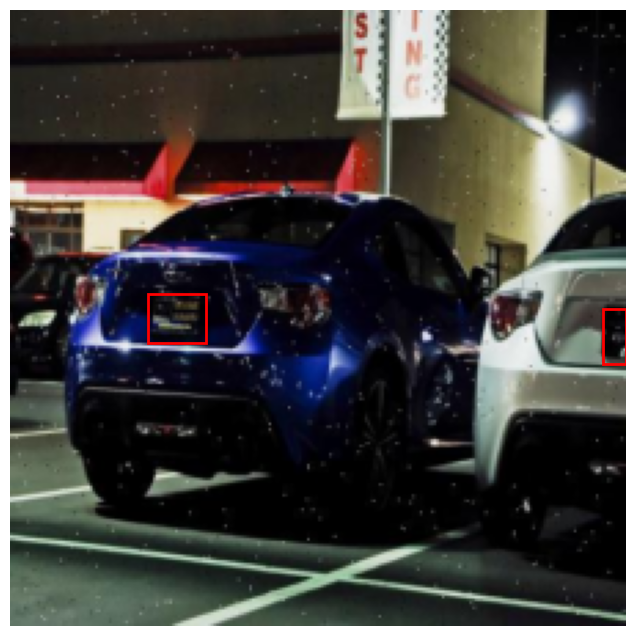

In [64]:
# Get one sample
img, bbox, labels = train_ds[197]  # img: Tensor [C,H,W], targets: Tensor [[x, y, w, h]]

display_image_with_bboxes(img, bbox)

In [51]:
import torchvision.transforms as T

IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

def get_valid_indices(dataset):
    valid_indices = []
    print("Filtrage des images sans objets...")
    for i in range(len(dataset)):
        try:
            _, bboxes, _ = dataset[i]
            if len(bboxes) > 0:
                valid_indices.append(i)
        except Exception:
            # En cas de fichier corrompu ou illisible
            continue
    print(f"Filtrage terminé : {len(valid_indices)} images valides sur {len(dataset)}.")
    return valid_indices


IMG_SIZE = 224

# Génération des indices filtrés
train_indices = get_valid_indices(train_dataset)
val_indices = get_valid_indices(val_dataset)

# Création des datasets finaux
train_ds = OneObjectDataset(train_dataset, transform, IMG_SIZE, indices=train_indices)
val_ds = OneObjectDataset(val_dataset, transform, IMG_SIZE, indices=val_indices)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

Filtrage des images sans objets...
Filtrage terminé : 25452 images valides sur 25470.
Filtrage des images sans objets...
Filtrage terminé : 1073 images valides sur 1073.


### 3. Model Definition

In [65]:
import torch.nn as nn
import torch.nn.functional as F

class OneObjectCNN(nn.Module):
    def __init__(self, num_classes=80):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.bbox_head = nn.Linear(64, 4) #regression head
        self.class_head = nn.Linear(64, num_classes) #classification head

    def forward(self, x): #input x, the image
        h = self.features(x)
        h = h.view(h.size(0), -1)
        bbox = self.bbox_head(h)
        cls = self.class_head(h)
        return bbox, cls #output the box and the class


In [66]:
one_net = OneObjectCNN()
print(one_net)

OneObjectCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (bbox_head): Linear(in_features=64, out_features=4, bias=True)
  (class_head): Linear(in_features=64, out_features=80, bias=True)
)


In [67]:

from torchinfo import summary
summary(one_net, input_size=(3,3, 768, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
OneObjectCNN                             [3, 4]                    --
├─Sequential: 1-1                        [3, 64, 1, 1]             --
│    └─Conv2d: 2-1                       [3, 16, 768, 1024]        448
│    └─ReLU: 2-2                         [3, 16, 768, 1024]        --
│    └─MaxPool2d: 2-3                    [3, 16, 384, 512]         --
│    └─Conv2d: 2-4                       [3, 32, 384, 512]         4,640
│    └─ReLU: 2-5                         [3, 32, 384, 512]         --
│    └─MaxPool2d: 2-6                    [3, 32, 192, 256]         --
│    └─Conv2d: 2-7                       [3, 64, 192, 256]         18,496
│    └─ReLU: 2-8                         [3, 64, 192, 256]         --
│    └─AdaptiveAvgPool2d: 2-9            [3, 64, 1, 1]             --
├─Linear: 1-2                            [3, 4]                    260
├─Linear: 1-3                            [3, 80]                   5,200
Tot

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OneObjectCNN(num_classes=1).to(device)

bbox_loss_fn = nn.MSELoss() 
cls_loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
acc_history = []


### 4. Training and Evaluation

In [69]:
for epoch in range(5):
    running_loss = 0.0 # On utilise un nom différent de la loss du batch
    correct = 0
    total = 0

    for img, bbox, label in train_loader:
        img, bbox, label = img.to(device), bbox.to(device), label.to(device)
        
        bbox = bbox.squeeze(1) 
        
        optimizer.zero_grad()
        pred_bbox, pred_cls = model(img)
        
        l_reg = bbox_loss_fn(pred_bbox, bbox)
        l_cls = cls_loss_fn(pred_cls, label)
        
        batch_loss = l_reg + l_cls # La loss de ce batch précis
        
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item() # Accumulation correcte

        # Accuracy
        preds = torch.argmax(pred_cls, dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}")

KeyboardInterrupt: 

### 5. Reading Parts